In [1]:
from fgbuster import harmonic_ilc_alm
import healpy as hp
import pysm3
import pysm3.units as u
import sys
sys.path.append('../')
import curvedsky as cs
import cmb
from database import surveys,noise
import os
import numpy as np
from tqdm import tqdm
from utils import camb_clfile
import mpi
import matplotlib.pyplot as plt
import pickle as pl
from fgbuster import (CMB, Dust, Synchrotron,  # sky-fitting model
                      basic_comp_sep)

In [57]:
class INST:
    def __init__(self,beam,frequency):
        self.Beam = beam
        self.fwhm = beam
        self.frequency = frequency

class SimExperiment:

    def __init__(self,infolder,outfolder,dnside,maskpath,fwhm,fg_dir,fg_str,table,len_cl_file,Fl=0,Fh=500 ):

        self.infolder = infolder
        self.outfolder = outfolder
        self.lmax = (3*dnside)-1
        self.fwhm = np.radians(fwhm/60)
        self.fg_dir = fg_dir
        self.fg_str = fg_str
        table = surveys().get_table_dataframe(table)
        self.table = table[(table.frequency>Fl) & (table.frequency<Fh)]
        self.mask = hp.ud_grade(hp.read_map(maskpath,verbose=False),dnside)
        self.fsky = np.mean(self.mask)
        self.dnside = dnside
        self.Tcmb  = 2.726e6
        self.cl_len = cmb.read_camb_cls(len_cl_file,ftype='lens',output='array')[:,:self.lmax+1]

        if mpi.rank == 0:
            os.makedirs(self.outfolder,exist_ok=True)
        print(f"using {self.infolder} and {self.fg_dir} saving to {self.outfolder}")

    def get_inv_w_noise(self):
        nP = np.around(noise(np.array(self.table.depth_p)),2)
        nT = np.around(nP/np.sqrt(2),2)
        return nT,nP

    def get_cmb(self,idx):
        fname = os.path.join(self.infolder,f"cmb_sims_{idx:04d}.fits")
        return hp.ud_grade(hp.read_map(fname,(0,1,2)),self.dnside)

    def get_fg(self,v):
        fname = os.path.join(self.fg_dir,f"{self.fg_str}_{int(v)}.fits")
        return hp.ud_grade(hp.read_map(fname,(0,1,2)),self.dnside)


    def get_noise(self,depth_i,depth_p):
        t = hp.synalm(np.ones(self.lmax+1)*(np.radians(depth_i/60)**2),lmax=self.lmax)
        e = hp.synalm(np.ones(self.lmax+1)*(np.radians(depth_p/60)**2),lmax=self.lmax)
        b = hp.synalm(np.ones(self.lmax+1)*(np.radians(depth_p/60)**2),lmax=self.lmax)
        return hp.alm2map([t,e,b],nside=self.dnside)

    def get_total_maps(self,idx,v,n_t,n_p):
        maps = self.get_cmb(idx) + self.get_fg(v) +self.get_noise(n_t,n_p)
        return maps*self.mask
    
    def get_noFG_maps(self,idx):
        fsky = f"{self.fsky:.1f}".replace('.','p')
        fname = os.path.join(self.outfolder,f"exp_noFG_sims_fsky_{fsky}_{idx:04d}.fits")
        if os.path.isfile(fname):
            return hp.read_map(fname,(0,1,2))
        else:
            n_t,n_p = self.get_inv_w_noise()
            maps = hp.smoothing(self.get_cmb(idx),fwhm=self.fwhm) + self.get_noise(n_t,n_p)
            hp.write_map(fname,maps)
            return maps
    
    def get_maps_arr(self,idx,v,n_t,n_p):
        arr = []
        for i in tqdm(range(len(v)),desc="Making map",unit='Freq'):
            arr.append(self.get_total_maps(idx,v[i],n_t[i],n_p[i]))
        return np.array(arr)
    
    def get_cs(self,idx):
        components = [CMB(), Dust(353.), Synchrotron(23.)]
        freq = np.array(self.table.frequency)
        N_p = np.array(self.table.depth_p)
        N_t = N_p*np.sqrt(2)
        instrument = INST(None,freq)
        return basic_comp_sep(components, instrument, self.get_maps_arr(idx,freq,N_t,N_p))

        
    def get_cs_maps(self,idx):
        fsky = f"{self.fsky:.1f}".replace('.','p')
        fname = os.path.join(self.outfolder,f"exp_sims_fsky_{fsky}_{idx:04d}.fits")
        if os.path.isfile(fname):
            return hp.read_map(fname,(0,1,2))
        else:
            result = self.get_cs(idx)
            maps = hp.smoothing([result.s[0,0],result.s[0,0],result.s[0,0]],fwhm=self.fwhm)
            hp.write_map(fname,maps)
            return maps
            

    def get_cinv_sim(self,idx,noFG=False):
        fsky = f"{self.fsky:.1f}".replace('.','p')
        _name = "cinv_noFG_sim" if noFG else "cinv_sim"
        fname = os.path.join(self.outfolder,f"{_name}_fsky_{fsky}_{idx:04d}.pkl")
        if os.path.isfile(fname):
            return pl.load(open(fname,'rb'))
        else:
            _,sigma = self.get_inv_w_noise()
            beam = hp.gauss_beam(self.fwhm,lmax=self.lmax,pol=True).T
            Bl = np.reshape(beam[2],(1,self.lmax+1))
            invn = self.mask * (np.radians(sigma/60)/self.Tcmb)**-2
            invN = np.reshape(np.array((invn,invn)),(2,1,hp.nside2npix(self.dnside)))
            T,Q,U = self.get_noFG_maps(idx) if noFG else self.get_cs_maps(idx)
            QU = np.reshape(np.array((Q,U)),(2,1,hp.nside2npix(self.dnside)))/self.Tcmb
            E,B = cs.cninv.cnfilter_freq(2,1,self.dnside,self.lmax,self.cl_len[1:3,:],
                                         Bl,invN,QU,chn=1,itns=[1000],eps=[1e-5],ro=10)
            pl.dump((E,B),open(fname,'wb'))
            return E, B

In [58]:
nside = 512
cl_len = camb_clfile('/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lensed_dls.dat')

In [59]:
outfolder = os.path.join(os.environ['SCRATCH'],"new_fg")
infolder = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD/CMB_Lensed_Maps/CMB/'
dnside = 512
maskpath8 = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/Masks/LB_Nside2048_fsky_0p8_binary.fits'
maskpath7 = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/Masks/LB_Nside2048_fsky_0p7_binary.fits'
maskpath6 = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/Masks/LB_Nside2048_fsky_0p6_binary.fits'
fwhm = 30
fg_dir = '/global/cscratch1/sd/lonappan/S4BIRD/FG'
fg_str = "s0d0"
table = "LITEBIRD_V1"
cl_len = '/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lensed_dls.dat'
sim = SimExperiment(infolder,outfolder,dnside,maskpath8,fwhm,fg_dir,fg_str,table,cl_len)

using /project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD/CMB_Lensed_Maps/CMB/ and /global/cscratch1/sd/lonappan/S4BIRD/FG saving to /global/cscratch1/sd/lonappan/new_fg


In [60]:
r = sim.get_cs(0)

Making map: 100%|██████████| 15/15 [07:18<00:00, 29.21s/Freq]


In [68]:
b = hp.gauss_beam(np.radians(.5),lmax=sim.lmax)
alm = hp.map2alm(r.s[0,0])
alm_d = hp.almxfl(alm,1/b)

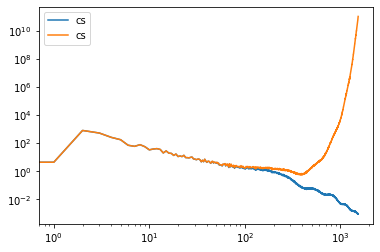

In [69]:
plt.loglog(hp.alm2cl(alm)/.8,label='cs')
plt.loglog(hp.alm2cl(alm_d)/.8,label='cs')
plt.legend()

In [13]:
cmb_a = hp.map2alm((sim.get_cmb(0)+sim.get_noise(1.5,2.16))*sim.mask)

In [56]:
hp.mollview(r.s[0,2])

AttributeError: 'tuple' object has no attribute 's'

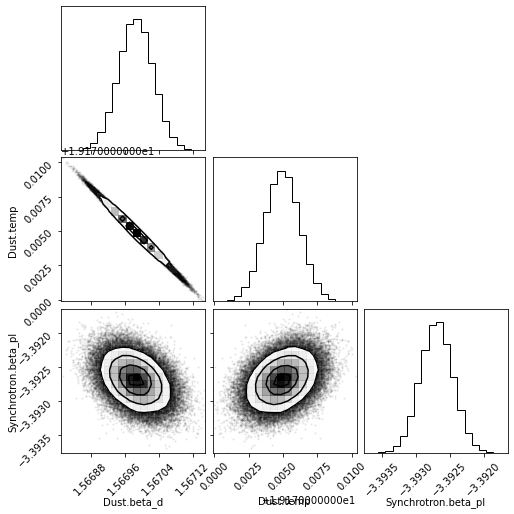

In [61]:
from fgbuster.visualization import corner_norm
corner_norm(r.x, r.Sigma, labels=r.params)